# Questions to consider
- how to deal with misspellings


Notes:
- Skip polyglot

# NLP pipeline
Objective: create a NLP pipeline that is reusable

Other things to check
- n-grams - ie. word pairs in 2-gram


# Example: Amazon product reviews
Data source:
- https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M
- amazon_review_full_csv.tar.gz

Data overview:
- Amazon reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 1 to 5. 
- In total there are 3,000,000 training samples and 650,000 testing samples.
- The files train.csv and test.csv contain all the training samples as comma-sparated values. 
- There are 3 columns in them, corresponding to class index (1 to 5), review title and review text. 
- The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

# Import Packages

In [33]:
import re
import os
import nltk
from nltk.tokenize import (word_tokenize, sent_tokenize, 
regexp_tokenize)
# for tweets
# from nltk.tokenize import TweetTokenizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import spacy

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import (CountVectorizer, 
TfidfVectorizer)
# NB works well with CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# if need to display images
from IPython.display import Image, SVG
SVG(filename='Images/nlp_linelength.svg')

# Load files

In [2]:
filepath = r'/Users/joe/Documents/GitHub/portfolio/support files/\
amazon_review_full_csv'
trainfile = 'train.csv'
testfile = 'test.csv'

In [3]:
pwd

'/Users/joe/Documents/GitHub/Python-reference'

In [4]:
traindf = pd.read_csv(os.path.join(filepath, trainfile), sep=",",
                  names=('rating','title','review'))

In [5]:
testdf = pd.read_csv(os.path.join(filepath, testfile), sep=",",
                  names=('rating','title','review'))

In [6]:
print(traindf.shape, testdf.shape)

(3000000, 3) (650000, 3)


In [8]:
# limit size of data
traindf = traindf.head(100000)
testdf = traindf.head(10000)
print(traindf.shape, testdf.shape)

(100000, 3) (10000, 3)


In [9]:
traindf.head(5)

,rating,title,review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [10]:
testdf.head(5)

,rating,title,review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


# Test word_tokenize

In [9]:
traindf.iloc[0,2]

'Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!'

In [10]:
words = word_tokenize(traindf.iloc[0,2])
words

['Gave',
 'this',
 'to',
 'my',
 'dad',
 'for',
 'a',
 'gag',
 'gift',
 'after',
 'directing',
 '``',
 'Nunsense',
 ',',
 "''",
 'he',
 'got',
 'a',
 'reall',
 'kick',
 'out',
 'of',
 'it',
 '!']

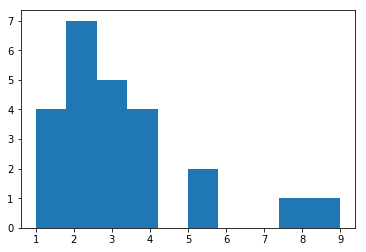

In [11]:
# make a list of word lengths
word_lengths = [len(w) for w in words]

plt.hist(word_lengths)
plt.show()

# Test sent_tokenize

In [12]:
sent_tokenize(traindf.iloc[1,2])

['I hope a lot of people hear this cd.',
 'We need more strong and positive vibes like this.',
 'Great vocals, fresh tunes, cross-cultural happiness.',
 'Her blues is from the gut.',
 'The pop sounds are catchy and mature.']

# Create gensim dictionary and corpus

In [13]:
traindf.review.head(5).values.tolist()

['Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!',
 'I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.',
 "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the 

In [14]:
# test
my_documents = traindf.review.head(10).values.tolist()
tokenized_docs = [word_tokenize(doc.lower()) for doc in my_documents]
dictionary = Dictionary(tokenized_docs)
# print(dictionary.token2id)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [15]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(2, 2),
  (4, 1),
  (18, 1),
  (21, 2),
  (23, 5),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(2, 2),
  (4, 3),
  (8, 2),
  (14, 1),
  (16, 1),
  (18, 1),
  (21, 5),
  (22, 4),
  (23, 3),
  (24, 3),
  (25, 1),
  (28, 1),
  (38, 6),
  (39, 5),
  (41, 1),
  (50, 3),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
 

In [16]:
# sanity check: look at first 10 word ids with their frequency counts 
#  from the 2nd document
print(corpus[1][:10])

[(2, 2), (4, 1), (18, 1), (21, 2), (23, 5), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1)]


In [ ]:
#################

# Insert text preprocessing? 

In [ ]:
# documents contain movie reviews
# note: abbreviated to 50000 documents
my_documents = traindf.review.head(50000).values.tolist()

# simple brief example tokenizing and lowercase
tokenized_docs = [word_tokenize(doc.lower()) for doc in my_documents]

#################
# options for further text processing
# can also remove punctuation and stop words
# Tokenize the article: tokens
tokens = word_tokenize(article)

# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokens]

# Create a Counter with the lowercase tokens: bow_simple
bow_simple = Counter(lower_tokens)

# Print the 10 most common tokens
print(bow_simple.most_common(10))
#######
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in english_stops]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize all tokens into a new list: lemmatized
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# Create the bag-of-words: bow
bow = Counter(lemmatized)

# Print the 10 most common tokens
print(bow.most_common(10))
#################

# start corpus: use Dictionary class to map id to each token
dictionary = Dictionary(tokenized_docs)

# create a gensim corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# view corpus - a list of lists, each list item is 1 document
# form: (id, frequency)

## 1. gensim: create corpus

In [11]:
# documents contain movie reviews
# note: abbreviated to 50000 documents
my_documents = traindf.review.head(50000).values.tolist()

# lowercase and word tokenizing
tokenized_docs = [word_tokenize(doc.lower()) for doc in my_documents]

# start corpus: use Dictionary class to map id to each token
dictionary = Dictionary(tokenized_docs)

# create a gensim corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# view corpus - a list of lists, each list item is 1 document
# form: (id, frequency)

In [12]:
# sanity check: look at dictionary token and id
dictionary.token2id

{'!': 0,
 "''": 1,
 ',': 2,
 '``': 3,
 'a': 4,
 'after': 5,
 'dad': 6,
 'directing': 7,
 'for': 8,
 'gag': 9,
 'gave': 10,
 'gift': 11,
 'got': 12,
 'he': 13,
 'it': 14,
 'kick': 15,
 'my': 16,
 'nunsense': 17,
 'of': 18,
 'out': 19,
 'reall': 20,
 'this': 21,
 'to': 22,
 '.': 23,
 'and': 24,
 'are': 25,
 'blues': 26,
 'catchy': 27,
 'cd': 28,
 'cross-cultural': 29,
 'fresh': 30,
 'from': 31,
 'great': 32,
 'gut': 33,
 'happiness': 34,
 'hear': 35,
 'her': 36,
 'hope': 37,
 'i': 38,
 'is': 39,
 'like': 40,
 'lot': 41,
 'mature': 42,
 'more': 43,
 'need': 44,
 'people': 45,
 'pop': 46,
 'positive': 47,
 'sounds': 48,
 'strong': 49,
 'the': 50,
 'tunes': 51,
 'vibes': 52,
 'vocals': 53,
 'we': 54,
 "'": 55,
 "'d": 56,
 "'game": 57,
 "'m": 58,
 "'s": 59,
 'any': 60,
 'be': 61,
 'beauty': 62,
 'been': 63,
 'best': 64,
 'bit': 65,
 'but': 66,
 'buy': 67,
 'disagree': 68,
 'every': 69,
 'fade.the': 70,
 'feel': 71,
 'figured': 72,
 'going': 73,
 'if': 74,
 'in': 75,
 'its': 76,
 'listening':

In [13]:
# sanity check: look at first 10 word ids with their frequency counts 
#  from the 2nd document
print(corpus[1][:10])

[(2, 2), (4, 1), (18, 1), (21, 2), (23, 5), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1)]


## 2. gensim: create a tf-idf model

In [14]:
# use bag of words corpus and translate to TfidfModel
tfidf = TfidfModel(corpus)

In [15]:
# reference each document like a dictionary
# displays [(token_id, token_weights)]
tfidf[corpus[1]]

[(2, 0.01986542514235891),
 (4, 0.009670564372163796),
 (18, 0.014603081325142419),
 (21, 0.02394427960261586),
 (23, 0.008009350152255625),
 (24, 0.017120182403592487),
 (25, 0.046731095776159325),
 (26, 0.2274864647257741),
 (27, 0.22033262254283312),
 (28, 0.11403784680523987),
 (29, 0.4018838776964095),
 (30, 0.2094822997039569),
 (31, 0.06301992607999961),
 (32, 0.06821228045601305),
 (33, 0.31253946803324956),
 (34, 0.2649682185098172),
 (35, 0.15830301418490395),
 (36, 0.10167012931352057),
 (37, 0.15161403571746326),
 (38, 0.012424377323207442),
 (39, 0.01580335768549762),
 (40, 0.05819096864793154),
 (41, 0.11496164131924472),
 (42, 0.24284948776090634),
 (43, 0.06847880826489389),
 (44, 0.12664786489785124),
 (45, 0.10388046230349512),
 (46, 0.18538486816050764),
 (47, 0.20506821676966816),
 (48, 0.16293449892253717),
 (49, 0.17253149721844768),
 (50, 0.008353822879747334),
 (51, 0.21516137711421968),
 (52, 0.32465879579786927),
 (53, 0.20263771196076216),
 (54, 0.09759696550

## 3. determine new significant terms for your corpus by applying gensim's tf-idf

In [16]:
# Save the 2nd document: doc
doc = corpus[1]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[doc]

# Print the first five weights
print(tfidf_weights[:5])

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, 
                              key=lambda w: w[1], 
                              reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary.get(term_id), weight)

[(2, 0.01986542514235891), (4, 0.009670564372163796), (18, 0.014603081325142419), (21, 0.02394427960261586), (23, 0.008009350152255625)]
cross-cultural 0.4018838776964095
vibes 0.32465879579786927
gut 0.31253946803324956
happiness 0.2649682185098172
mature 0.24284948776090634


# Text preprocessing
Remove
- stop words
- non-alpha characters
- lemmatize
- perform bag-of-words

In [ ]:
# Tokenize the article: tokens
tokens = word_tokenize(article)

# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokens]

# Create a Counter with the lowercase tokens: bow_simple
bow_simple = Counter(lower_tokens)

# Print the 10 most common tokens
print(bow_simple.most_common(10))

# [(',', 151), ('the', 150), ('.', 89), ('of', 81), ("''", 68), 
#  ('to', 63), ('a', 60), ('in', 44), ('and', 41), ('(', 40)]

In [ ]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in english_stops]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize all tokens into a new list: lemmatized
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# Create the bag-of-words: bow
bow = Counter(lemmatized)

# Print the 10 most common tokens
print(bow.most_common(10))

# gensim
Advantages
- uses top academic models to perform complex tasks
    - building document or word vectors
    - performing topic identification and document comparison
- LDA used for topic analysis and modeling
- corpus/corpora = set of texts used to perform NLP tasks
- gensim models can be easily saved, updated, and reused
- dictionary can also be updated
    - with new texts
    - words that meet certain thresholds
    - then use for feature exercises

In [ ]:
# use bag of words corpus and translate to TfidfModel
tfidf = TfidfModel(corpus)

# reference each document like a dictionary
# displays [(token_id, token_weights)]
tfidf[corpus[1]]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[doc]

# Print the first five weights
print(tfidf_weights[:5])

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, 
                              key=lambda w: w[1], 
                              reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary.get(term_id), weight)
    

# Named-entity recognition (NER)
- Who? What? When? Where?


# spaCy
Advantages using spaCy for NER
- focus on creating NLP pipelines to generate model and corpora
- informal language corpora
    - easily find entities in Tweets and chat messages

- NLP library similar to gensim, with different implementations
- additional NER compared to nltk
    - NORP, CARDINAL, MONEY, WORKOFART, LANGUAGE, EVENT
- displaCy
    - entity recognition visualization tool to view parse trees
    - which uses Node.js to create interactive text


In [ ]:
nlp = spacy.load('en')

# Instantiate the English model: nlp
# Additional args to improve execution time
nlp = spacy.load('en', tagger=False, parser=False, 
                 matcher=False)

# load new document
doc = nlp("""Berlin is the capital of Germany;
and the residence of Chancellor Angela Merkel.""")

# named entities are stored in .ents
print(doc.ents)

# check out each label (.label_) using indexing
print(doc.ents[0], doc.ents[0].label_)

# Print all of the found entities and their labels
for ent in doc.ents:
    print(ent.label_, ent.text)

# ML pipeline

In [17]:
# load data into a dataframe
# df = ...

# set text
X = traindf['review']
# set target label
y = traindf['rating']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=53)

## 1. countvectorizer

In [23]:
# CountVectorizer - bag-of-words

# create a count vectorizer and remove stop_words
count_vectorizer = CountVectorizer(stop_words='english')
# create bag-of-words vectors on train/test sets
# fit_transform will create a bag-of-words dictionary 
#  and vectors for each document
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
# note: if you have unknown words in test set only, may
#  need more data or remove those words from the test dataset

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['00', '000', '000cps', '000fortunately', '000if', '000kb', '000sg', '000th', '001', '002']


## 2. tf-idf vectors

In [42]:
# tfidf vectors for documents
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.values)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

['00', '000', '000cps', '000fortunately', '000if', '000kb', '000sg', '000th', '001', '002']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
# inspect vectors in pandas dataframe

# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, 
                        columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, 
                        columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))


   00  000  000cps  000fortunately  000if  000kb  000sg  000th  001  002  \
0   0    0       0               0      0      0      0      0    0    0   
1   0    0       0               0      0      0      0      0    0    0   
2   0    0       0               0      0      0      0      0    0    0   
3   0    0       0               0      0      0      0      0    0    0   
4   0    0       0               0      0      0      0      0    0    0   

   ...    ér  ésta  éste  éstos  était  étoiles  étranger  été  éxitos  único  
0  ...     0     0     0      0      0        0         0    0       0      0  
1  ...     0     0     0      0      0        0         0    0       0      0  
2  ...     0     0     0      0      0        0         0    0       0      0  
3  ...     0     0     0      0      0        0         0    0       0      0  
4  ...     0     0     0      0      0        0         0    0       0      0  

[5 rows x 87592 columns]
    00  000  000cps  000fortunately  

# Tweaking alpha
- try gridsearchCV ?

In [34]:
# Create the list of alphas: alphas
alphas = np.arange(0,1,0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.3543939393939394

Alpha:  0.1
Score:  0.40145454545454545

Alpha:  0.2
Score:  0.40793939393939394

Alpha:  0.30000000000000004


/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.41193939393939394

Alpha:  0.4
Score:  0.4155151515151515

Alpha:  0.5
Score:  0.4166060606060606

Alpha:  0.6000000000000001
Score:  0.4172121212121212

Alpha:  0.7000000000000001
Score:  0.4195757575757576

Alpha:  0.8
Score:  0.4210606060606061

Alpha:  0.9
Score:  0.42193939393939395



# Tune alpha with gridsearch - tinkering here

In [41]:
# # Create the list of alphas: alphas
# alphas = np.arange(0,1,0.1)

# # Define train_and_predict()
# def train_and_predict(alpha):
#     # Instantiate the classifier: nb_classifier
#     nb_classifier = MultinomialNB(alpha=alpha)
#     # Fit to the training data
#     nb_classifier.fit(tfidf_train, y_train)
#     # Predict the labels: pred
#     pred = nb_classifier.predict(tfidf_test)
#     # Compute accuracy: score
#     score = metrics.accuracy_score(y_test, pred)
#     return score

# CV and scaling in a pipeline
steps = [('nb', MultinomialNB())]
pipeline = Pipeline(steps)

# Specify hyperparameter space using a dictionary
parameters = {'nb__alpha':[0, 1, 0.1]}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(tfidf_train, y_train)
pred = cv.predict(tfidf_test)

# Compute and print metrics
# print best parameters
print("Tuned Model Parameters: {}".format(cv.best_params_))
# print("MultinomialNB training accuracy:", cv.score(X_train, y_train))
# print("Test Accuracy: {}".format(cv.score(X_test, y_test)))
# print(classification_report(y_test, pred))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Tuned Model Parameters: {'nb__alpha': 1}


# Run model

In [44]:
# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=alpha)
# Fit to the training data
nb_classifier.fit(tfidf_train, y_train)
# Predict the labels: pred
pred = nb_classifier.predict(tfidf_test)
# Compute accuracy: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.42193939393939395


# Inspect model

In [45]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])


1 [(-11.96514592841074, '000cps'), (-11.96514592841074, '000kb'), (-11.96514592841074, '000sg'), (-11.96514592841074, '000th'), (-11.96514592841074, '001'), (-11.96514592841074, '002'), (-11.96514592841074, '003'), (-11.96514592841074, '004g'), (-11.96514592841074, '008'), (-11.96514592841074, '0080'), (-11.96514592841074, '0083'), (-11.96514592841074, '00mini'), (-11.96514592841074, '00movie'), (-11.96514592841074, '0130944106'), (-11.96514592841074, '0140194703'), (-11.96514592841074, '014044100x'), (-11.96514592841074, '0140449191'), (-11.96514592841074, '015'), (-11.96514592841074, '016071'), (-11.96514592841074, '0199558292there')]
2 [(-7.048749421112344, 'better'), (-7.040163503384698, 'work'), (-7.0336663506418695, 'worst'), (-6.981009578428602, 'really'), (-6.979421783593806, 'bought'), (-6.947990337473621, 'dvd'), (-6.9006697846590574, 'did'), (-6.808287645648438, 'product'), (-6.802725100397831, 'good'), (-6.722444636014009, 'bad'), (-6.721830825864573, 'waste'), (-6.68267684

In [47]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '000cps',
 '000fortunately',
 '000if',
 '000kb',
 '000sg',
 '000th',
 '001',
 '002',
 '003',
 '004g',
 '007',
 '008',
 '0080',
 '0083',
 '00am',
 '00mini',
 '00movie',
 '00plus',
 '00pm',
 '01',
 '010',
 '0130944106',
 '0140194703',
 '014044100x',
 '0140449191',
 '015',
 '016',
 '016071',
 '0199558292there',
 '02',
 '020',
 '023',
 '028',
 '029',
 '0291i',
 '0291it',
 '03',
 '0316',
 '0316341142',
 '034',
 '036',
 '0385658389',
 '03movie',
 '03s',
 '04',
 '04bought',
 '04s',
 '05',
 '0517220784',
 '059',
 '05warning',
 '06',
 '061009',
 '0618260584',
 '06rate',
 '06s',
 '07',
 '0745',
 '0746',
 '075',
 '07i',
 '08',
 '081',
 '0830',
 '089',
 '08th',
 '09',
 '090',
 '0920205',
 '0967979013',
 '0conclusionthis',
 '0dictionary',
 '0f',
 '0go',
 '0l',
 '0mbps',
 '0mm',
 '0ne',
 '0o0n',
 '0s9',
 '0sx',
 '0this',
 '0x0444',
 '0x04a7',
 '10',
 '100',
 '1000',
 '10000',
 '10000000',
 '10000stars',
 '1000m',
 '1000mah',
 '1000pp',
 '1000s',
 '1000w',
 '1000x',
 '1001',
 '100409'

# Try n-gram (2)

In [ ]:
# Tokenize the article: tokens
tokens = word_tokenize(article)

# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokens]

# Create a Counter with the lowercase tokens: bow_simple
bow_simple = Counter(lower_tokens)

# Print the 10 most common tokens
print(bow_simple.most_common(10))

# [(',', 151), ('the', 150), ('.', 89), ('of', 81), ("''", 68), 
#  ('to', 63), ('a', 60), ('in', 44), ('and', 41), ('(', 40)]

# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in english_stops]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Lemmatize all tokens into a new list: lemmatized
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# Create the bag-of-words: bow
bow = Counter(lemmatized)

# Print the 10 most common tokens
print(bow.most_common(10))

In [ ]:
def preprocess(doc):
    
    
    return doc

In [49]:
# tfidf vectors for documents
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', preprocessor=preprocess,
                                   #ngram_range=(1,2),
                                   max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.values)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

['00', '00 00', '00 11', '00 150', '00 2000', '00 24', '00 25', '00 28', '00 3k', '00 40']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [50]:
# model

# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=alpha)
# Fit to the training data
nb_classifier.fit(tfidf_train, y_train)
# Predict the labels: pred
pred = nb_classifier.predict(tfidf_test)
# Compute accuracy: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.4415454545454545


In [51]:
# inspect model

# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

1 [(-14.29733286657654, '00 00'), (-14.29733286657654, '00 11'), (-14.29733286657654, '00 150'), (-14.29733286657654, '00 2000'), (-14.29733286657654, '00 25'), (-14.29733286657654, '00 28'), (-14.29733286657654, '00 3k'), (-14.29733286657654, '00 40'), (-14.29733286657654, '00 8x'), (-14.29733286657654, '00 advertised'), (-14.29733286657654, '00 afford'), (-14.29733286657654, '00 alll'), (-14.29733286657654, '00 amazon'), (-14.29733286657654, '00 arrived'), (-14.29733286657654, '00 avoid'), (-14.29733286657654, '00 bad'), (-14.29733286657654, '00 bargain'), (-14.29733286657654, '00 begining'), (-14.29733286657654, '00 best'), (-14.29733286657654, '00 better')]
2 [(-9.995747193616925, 'worst'), (-9.991951277482904, 'better'), (-9.980429434025897, 'work'), (-9.938638749341585, 'really'), (-9.92515176688316, 'bought'), (-9.902001689445786, 'dvd'), (-9.854287803334739, 'did'), (-9.755961062851906, 'good'), (-9.750407948471391, 'product'), (-9.690334997035244, 'waste'), (-9.681157758146565

# Other considerations
Sentiment Analysis
- complex problems sarcasm
- difficulty with negation
    - ie. I liked it, but it could have been better
- separate communities may use the same words differently
Language biases
- prejudices in text